In [1]:
import sys
from importlib import reload
import vqe_functions
from vqe_functions import*
import json
from scipy.interpolate import interp2d,CubicSpline,lagrange
from qiskit.algorithms.optimizers import SPSA,L_BFGS_B,COBYLA,QNSPSA,ADAM,NELDER_MEAD
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler import CouplingMap
from qiskit.utils import algorithm_globals
from qiskit.providers.fake_provider import FakeManila,FakeQuito,FakeLima,FakeKolkata
from qiskit.providers.fake_provider import FakePerth,FakeLagos,FakeNairobi,FakeJakarta
from qiskit.circuit.library import EfficientSU2
from qiskit.compiler import transpile

ModuleNotFoundError: No module named 'networkx'

In [72]:
reload(vqe_functions);

In [73]:
shots = 15000

# Functions

# Fixed field analysis

## Options

Getting parameters

In [74]:
with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_4q_ap_p3.json') as json_file:
    angles_4q_ap_bfgs_p3 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_4q_ap_p2.json') as json_file:
    angles_4q_ap_bfgs_p2 = json.load(json_file)

Initializing runtime

In [75]:
service = QiskitRuntimeService()
backend = service.backend('ibmq_qasm_simulator')

In [76]:
graph = get_line_graph(4)
model = 'ap'

In [77]:
#Lattice and model
graph = get_line_graph(4)
model = 'ap'

#values of g
g_exct_values = np.linspace(0.,1.5,100)
g_values = np.linspace(0.,1.5,25)

#exact result
exct_E,exct_m,exct_kk = get_exact_values(graph=graph,g_values=g_exct_values,model=model)


100%|██████████| 100/100 [00:01<00:00, 91.08it/s]


In [78]:
# VQE options
n_qubits = 4
p = 4
ap = np.sqrt(0.5)
graph = get_line_graph(n_qubits)
theta_list_c = ParameterVector('theta',length=3*p)
ansatz_c = get_ansatz_antip_ibm(graph,theta_list_c)
ansatz_hea = EfficientSU2(n_qubits,su2_gates='ry',reps=p)


cost_operator = get_h_op(graph,ap=ap,hx=0.5)
mag_op = get_mag_op(graph)
kk_op = get_kk_op(graph)
aux_operators = [mag_op,kk_op]

Comparing the ansatze

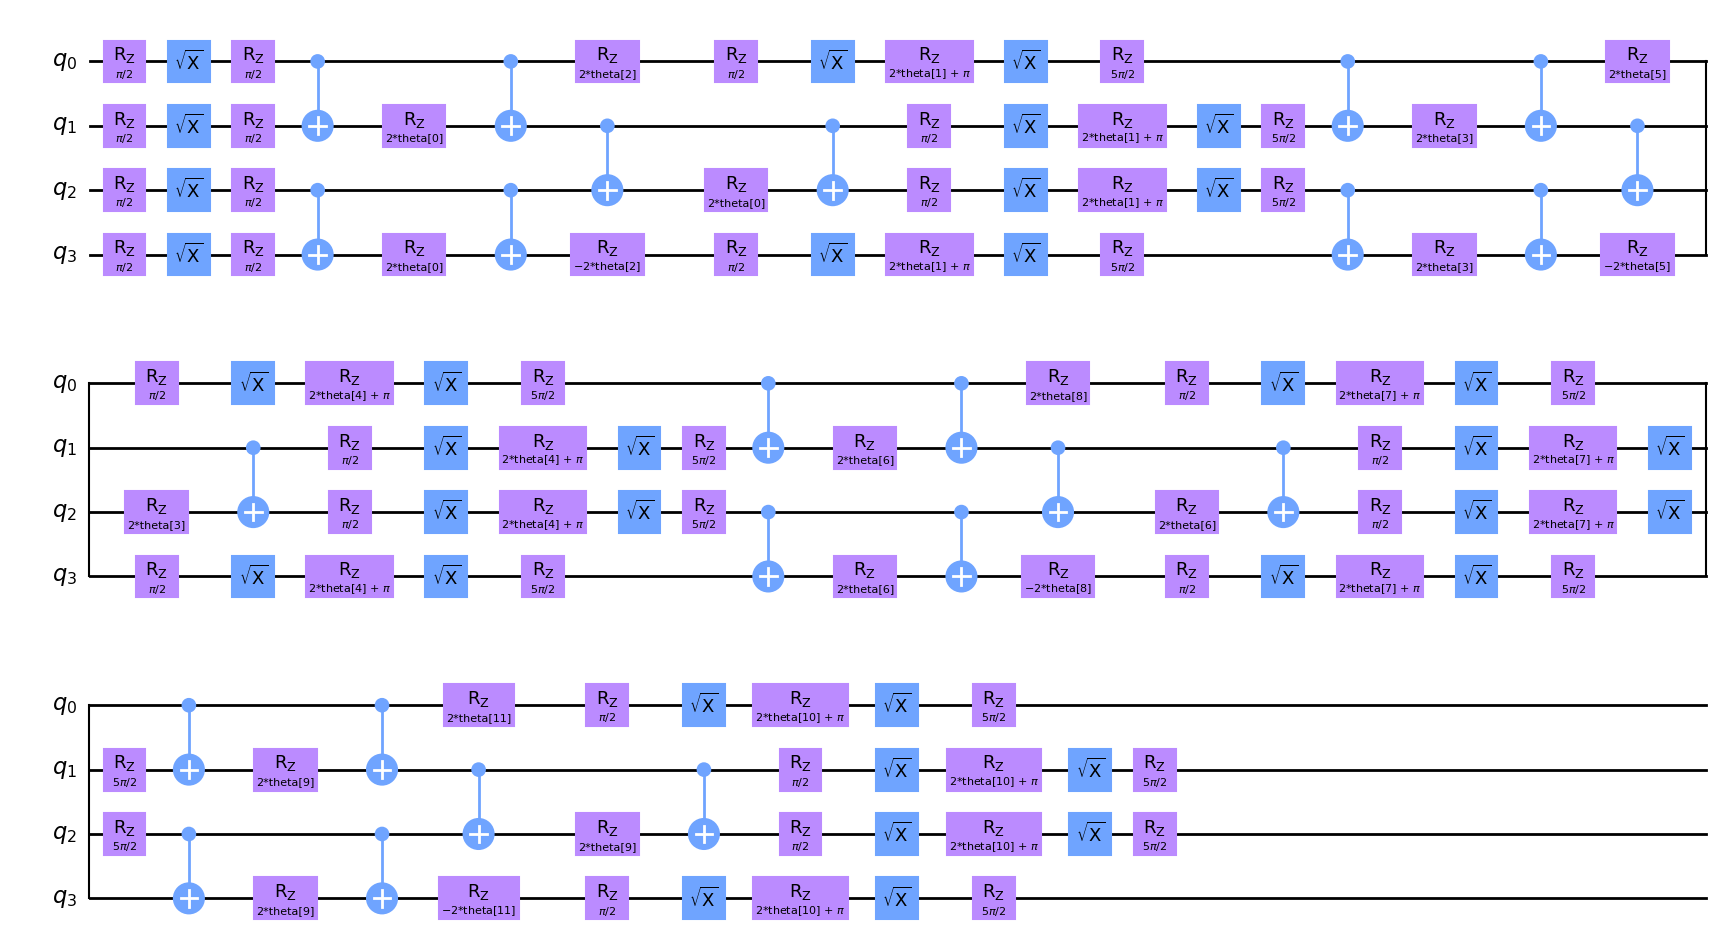

In [79]:
ansatz_c.draw('mpl')

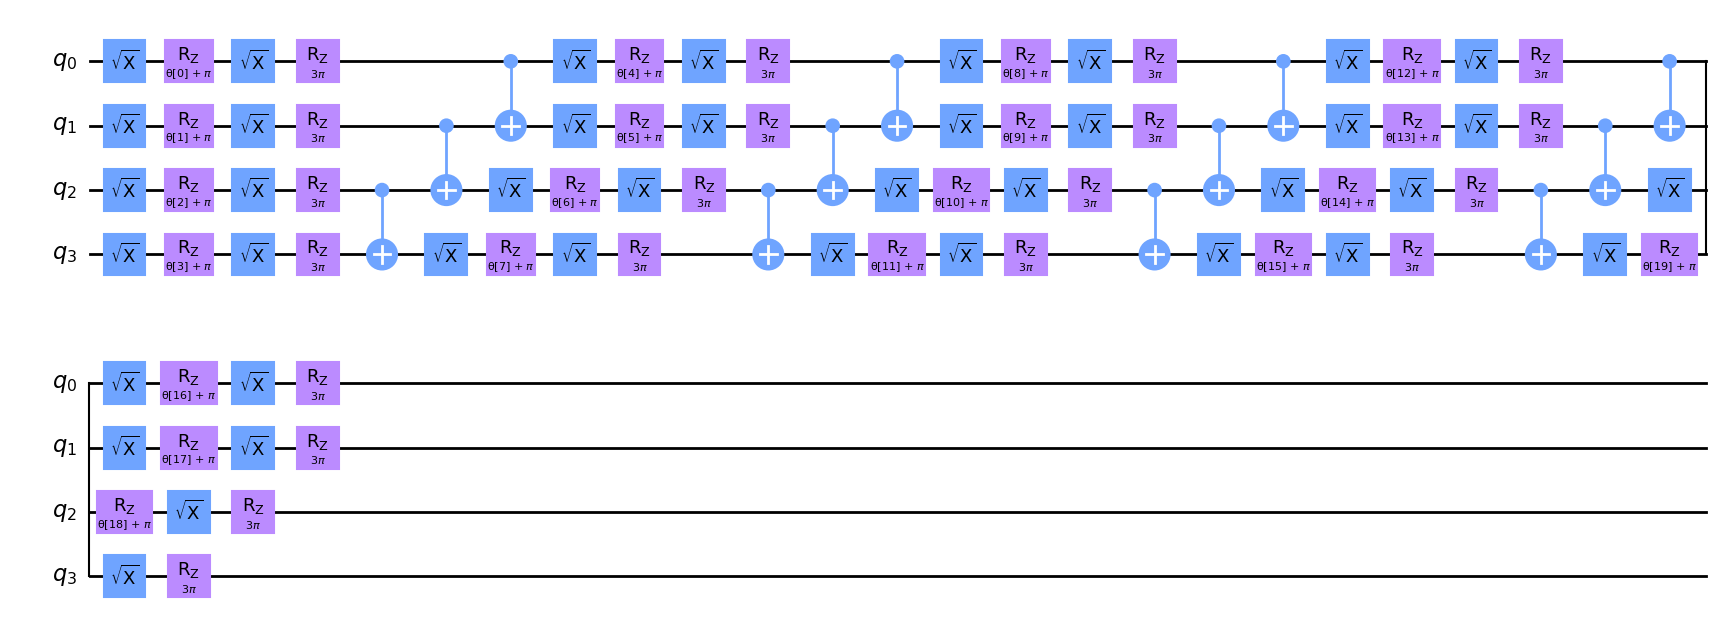

In [80]:
transpile(ansatz_hea,basis_gates=FakeNairobi().configuration().basis_gates).draw('mpl')

Exact critical energy

In [81]:
numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(operator=cost_operator,aux_operators=aux_operators)
exact_ec_4q = exact_result.eigenvalue
print(exact_result.eigenvalue)

-3.688399318425176


Setting callback

In [82]:
#Define callback function

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [83]:
from dataclasses import dataclass

In [84]:
@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count}", end="\r", flush=True)


log = VQELog([], [])

Noise models

In [85]:
shots = 9000
#EXACT QASM 
options_exct = Options()
options_exct.execution.shots = shots


# FAKE NAIROBI

fake_nairobi = FakeNairobi()
noise_nairobi = NoiseModel.from_backend(fake_nairobi)
options_noisy_nairobi = Options()
options_noisy_nairobi.execution.shots = shots
options_noisy_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map,
    "seed_simulator": 42
}

options_noisy_nairobi.optimization_level = 0 # no optimization
options_noisy_nairobi.resilience_level = 0 # M3 for Sampler and T-REx for Estimator

# Mitigated Nairobi
options_mitigated_nairobi = Options()
options_mitigated_nairobi.execution.shots = shots
options_mitigated_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map
}



# Set number of shots, optimization_level and resilience_level
options_mitigated_nairobi.optimization_level = 3
options_mitigated_nairobi.resilience_level = 3
#options_mitigated_nairobi.resilience.extrapolator = "LinearExtrapolator"
#options_mitigated_nairobi.resilience.noise_factors = [1,3,5,7]

In [86]:
sampler = Sampler()
fidelity = QNSPSA.get_fidelity(ansatz_c, sampler)

Optimizers

In [87]:
nelder_mead = NELDER_MEAD(maxiter=100)
qnspsa = QNSPSA(fidelity, maxiter=300)
spsa = SPSA(maxiter=600,
            trust_region=True,
            learning_rate=0.05,
            perturbation=0.1)
bfgs = L_BFGS_B(maxiter=20)
cobyla = COBYLA(maxiter=500)
adam = ADAM(maxiter=20,tol=0.005,lr=0.0035)

#Initial points
initial_point = angles_4q_ap_bfgs_p3['0.8125']
random_point = np.random.random(ansatz_hea.num_parameters)

## Running

Local primitives

In [93]:
ansatz_hea.num_parameters

20

In [92]:
len(np.random.random(ansatz_hea.num_parameters))

20

In [103]:
random_point = np.random.random(ansatz_hea.num_parameters)

In [106]:
log = VQELog([], [])
vqe_local = VQE(estimator=Estimator(options={'shots':15000,'seed':150}),
                ansatz=ansatz_hea,
                optimizer=cobyla,
                initial_point=random_point,
                callback=log.update)
result_local = vqe_local.compute_minimum_eigenvalue(cost_operator)
print(result_local.eigenvalue)

-3.6813068269624303


In [107]:
print(result_local.eigenvalue/exact_result.eigenvalue)

0.9980770814517518


In [101]:
optimal_parameters = result_local.optimal_point

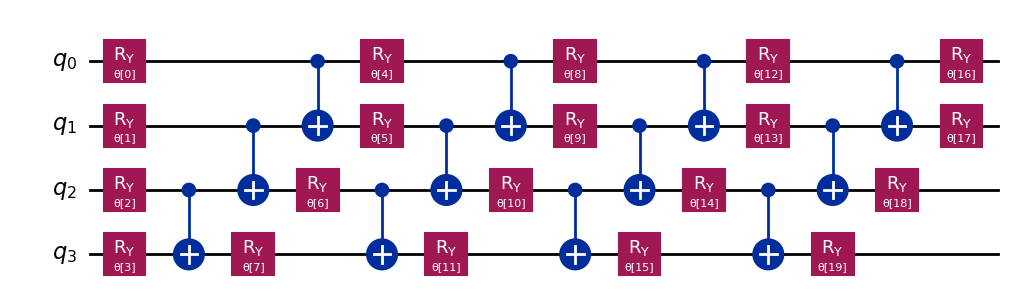

In [102]:
ansatz_hea.decompose(reps=1).draw('mpl',style='iqx')

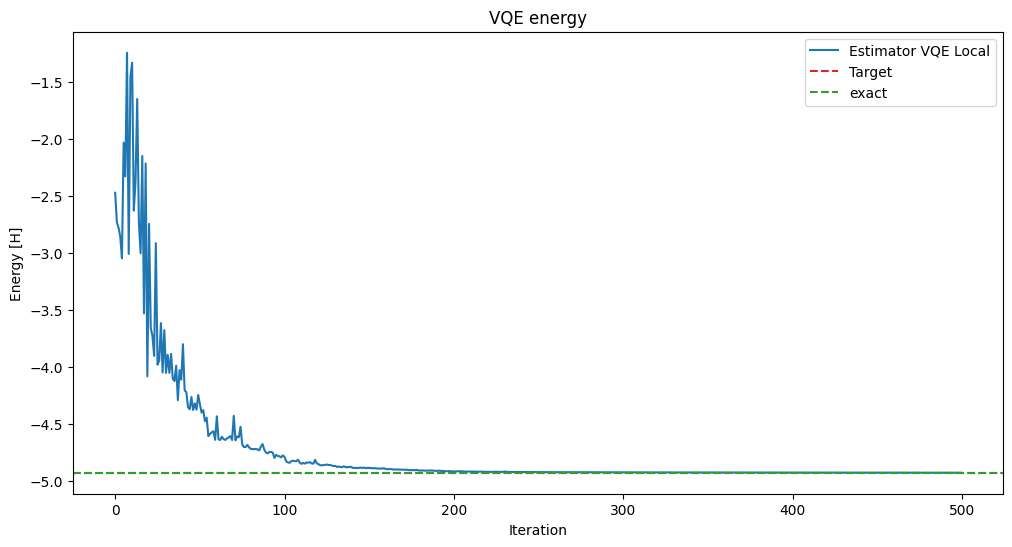

In [22]:
# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=result_local.eigenvalue, color="tab:red", ls="--", label="Target")
plt.axhline(y=exact_result.eigenvalue, color="tab:green", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [27]:
log = VQELog([], [])
vqe_local = VQE(estimator=Estimator(options={'shots':15000,'seed':150}),
                ansatz=ansatz_hea,
                optimizer=COBYLA(rhobeg=0.001),
                initial_point=optimal_parameters,
                callback=log.update)
result_local = vqe_local.compute_minimum_eigenvalue(cost_operator)
print(result_local.eigenvalue)

-4.92727423782608100


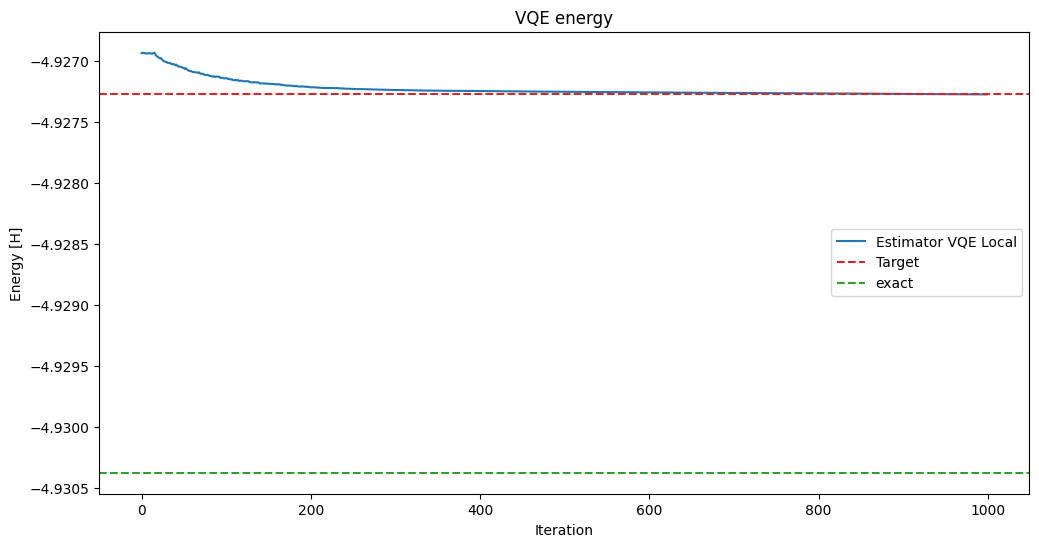

In [28]:
# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=result_local.eigenvalue, color="tab:red", ls="--", label="Target")
plt.axhline(y=exact_result.eigenvalue, color="tab:green", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [ ]:
# initial_point_spsa = result_local.optimal_point

In [ ]:
# log = VQELog([], [])
# vqe_local = VQE(estimator=Estimator(options={'shots':shots}),
#                 ansatz=ansatz_c,
#                 optimizer=SPSA(trust_region=True,learning_rate=0.001,perturbation=0.0001),
#                 initial_point=initial_point_spsa,
#                 callback=log.update)
# result_local_2 = vqe_local.compute_minimum_eigenvalue(cost_operator)
# print(result_local_2.eigenvalue)

In [30]:
estimator=Estimator(options={'shots':15000,'seed':110})
optimal_result = estimator.run(ansatz_hea,cost_operator,optimal_parameters).result()

In [31]:
optimal_result.values

array([-4.92674309])

Runtime Primitives

### HVA

In [35]:
# Main calculation
log = VQELog([], [])
optimizer = COBYLA(maxiter=1)
with Session(service=service, backend=backend) as session:
    options = options_mitigated_nairobi
    vqe = VQE(
        IBM_Estimator(session=session, options=options),
        ansatz_c,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(cost_operator)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    # if "simulator" not in backend:
    #     # Run once with ZNE error mitigation
    #     options.resilience_level = 1
    #     vqe = VQE(
    #         Estimator(session=session, options=options),
    #         ansatz_c,
    #         SPSA(1),
    #         initial_point=result.optimal_point,
    #     )
    #     result = vqe.compute_minimum_eigenvalue(cost_operator)
    #     print(f"Mitigated result: {result.optimal_value}")
    session.close()


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -3.0463385416666675,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7efc5461ce90>,
    'optimal_parameters': {   ParameterVectorElement(theta[0]): 0.4420484273618917,
                              ParameterVectorElement(theta[1]): -0.2381888166113337,
                              ParameterVectorElement(theta[7]): 0.7493388396974037,
                              ParameterVectorElement(theta[8]): 0.3824995160777631,
                              ParameterVectorElement(theta[6]): 0.8174669608974701,
                              ParameterVectorElement(theta[2]): 0.5353216966224885,
                              ParameterVectorElement(theta[4]): 0.14004436407890905,
                              ParameterVectorElement(theta[5]): 0.14026216815423248,
                              ParameterVectorElement(theta[3]): 0.35752453050956384},
    'optimal_point': array([ 0.4420

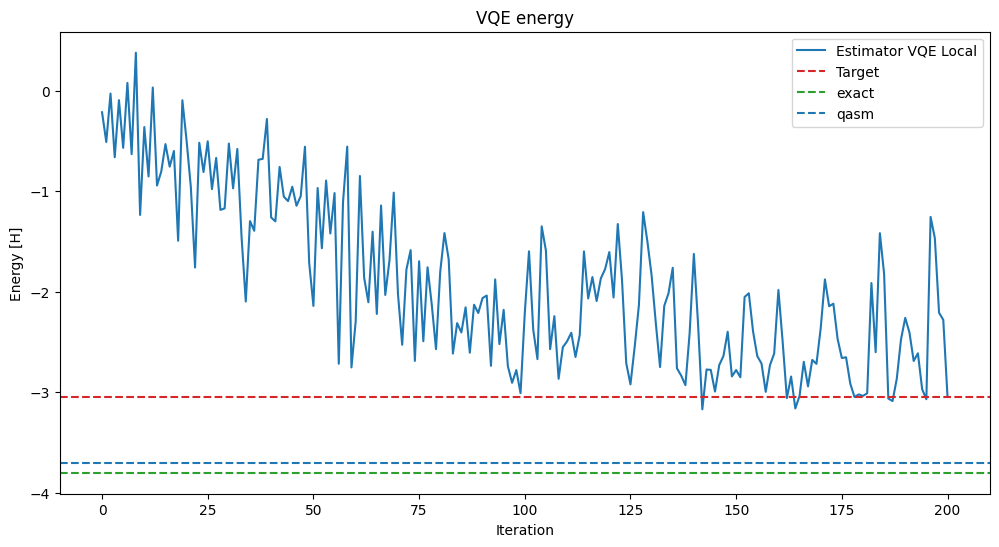

In [ ]:
# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=result.eigenvalue, color="tab:red", ls="--", label="Target")
plt.axhline(y=exact_result.eigenvalue, color="tab:green", ls="--", label="exact")
plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

### Hardware Efficient Ansatz (HEA)

In [34]:
with Session(service=service, backend=backend) as session:
    options = options_exct
    estimator_ibm = IBM_Estimator(session=session, options=options)
    optimal_result_ibm = estimator_ibm.run(ansatz_hea,cost_operator,optimal_parameters).result()
    session.close()


In [35]:
print(optimal_result_ibm)

EstimatorResult(values=array([-4.90893333]), metadata=[{'variance': 3.8654115555555557, 'shots': 15000}])


In [36]:
-3.77923681/-3.8031317682280226

0.9937170312036925

In [37]:
(-3.77923681+3.8031317682280226)/-3.8031317682280226

-0.006282968796307535

In [102]:
# Main calculation
log = VQELog([], [])
optimizer = cobyla
with Session(service=service, backend=backend) as session:
    options = options_exct
    vqe = VQE(
        IBM_Estimator(session=session, options=options),
        ansatz_hea,
        optimizer,
        callback=log.update,
        initial_point=np.random.random(ansatz_hea.num_parameters),
    )
    result = vqe.compute_minimum_eigenvalue(cost_operator)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    # if "simulator" not in backend:
    #     # Run once with ZNE error mitigation
    #     options.resilience_level = 1
    #     vqe = VQE(
    #         Estimator(session=session, options=options),
    #         ansatz_c,
    #         SPSA(1),
    #         initial_point=result.optimal_point,
    #     )
    #     result = vqe.compute_minimum_eigenvalue(cost_operator)
    #     print(f"Mitigated result: {result.optimal_value}")
    session.close()


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

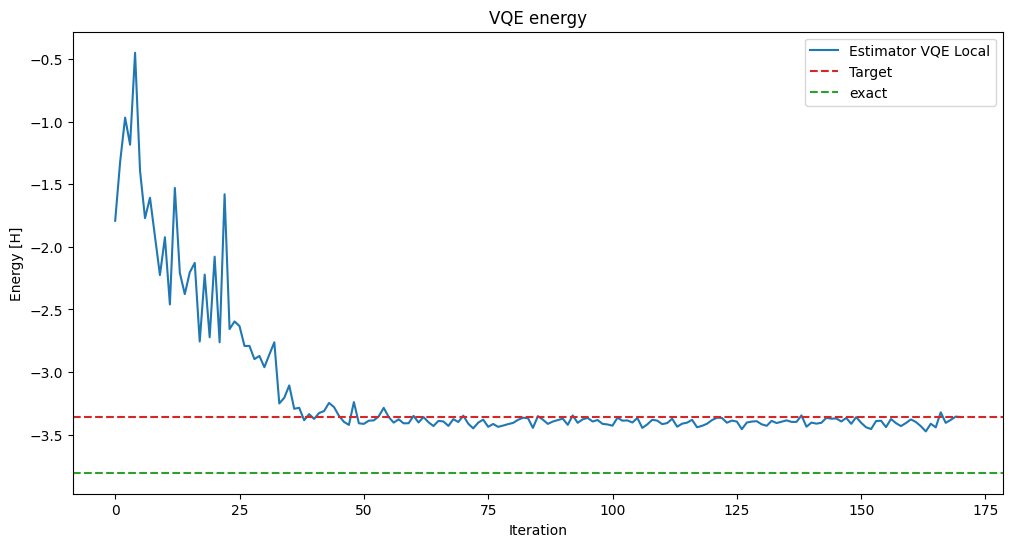

In [ ]:
# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=result.eigenvalue, color="tab:red", ls="--", label="Target")
plt.axhline(y=exact_result.eigenvalue, color="tab:green", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [ ]:
# def get_cost_function(ansatz, cost_operator,options,estimator,backend):
    
#     def cost_func(theta):
#         energy = estimator.run(ansatz, cost_operator, parameter_values=theta).result().values[0]
#         return energy

# Phase diagram

## Local primitives

In [21]:
def get_vqe_values_ap_hea(graph,
                          g_values,
                          p=1,
                          hx=0.5,
                          optimizer=COBYLA(),
                          shots=20000,
                          reps=1):
    """Runs the vqe to simulate the antiparallel model in
    the hardware efficient ansatz for different values of
    the antiparallel field"""
    
    n_qubits = len(graph.nodes())
    
    E_values = np.array([0. for i in range(len(g_values))])
    mag_values = np.array([0. for i in range(len(g_values))])
    kk_values = np.array([0. for i in range(len(g_values))])
    angles_dict = {}
    mag_op = get_mag_op(graph)
    kk_op = get_kk_op(graph)
    aux_operators = [mag_op,kk_op]
    
    rev_g_values = g_values[::-1]
    for i,g in enumerate(tqdm(rev_g_values)):
        estimator = Estimator(options={'shots':shots,'seed':170})
        ansatz_hea = EfficientSU2(n_qubits,su2_gates='ry',reps=p)
        cost_operator = get_h_op(graph,hx=hx,ap=g)
        
        if i == 0:
            resampled_energy = 0.
            for j in range(reps):
                initial_point = np.random.random(ansatz_hea.num_parameters)
                vqe = VQE(estimator=estimator,ansatz=ansatz_hea,
                            optimizer=COBYLA(500),initial_point=initial_point)
                sample_result = vqe.compute_minimum_eigenvalue(operator=cost_operator,
                                                            aux_operators=aux_operators)
                eigenvalue = sample_result.eigenvalue
                
                if eigenvalue < resampled_energy:
                    resampled_energy = eigenvalue
                    result = sample_result
            
            initial_point = result.optimal_point    

        else:
            vqe = VQE(estimator=estimator,ansatz=ansatz_hea,
                            optimizer=optimizer,initial_point=initial_point)
            result = vqe.compute_minimum_eigenvalue(operator=cost_operator,
                                                        aux_operators=aux_operators)
        
        E_values[i] = result.eigenvalue
        mag_values[i] = result.aux_operators_evaluated[0][0]
        kk_values[i] = np.real_if_close(result.aux_operators_evaluated[1][0])
        #optimal angles storage
        angles = list(result.optimal_point)
        angles_dict[str(round(g,14))] = angles


    return E_values,mag_values,kk_values,angles_dict

### One layer

In [22]:
E,m,kk,angles = get_vqe_values_ap_hea(graph,g_values,p=1,optimizer=COBYLA(100),reps=3)

100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


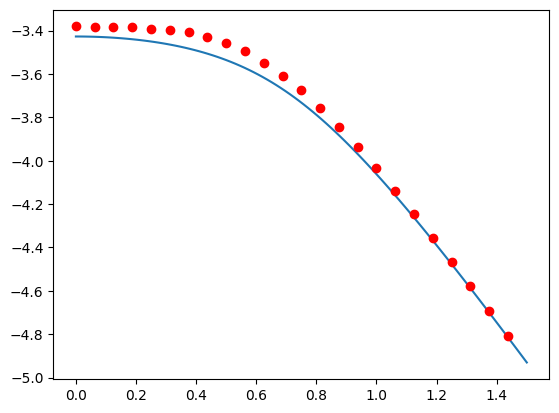

In [23]:
plt.plot(g_exct_values,exct_E)
plt.plot(g_values[::-1][1:],E[1:],'ro')

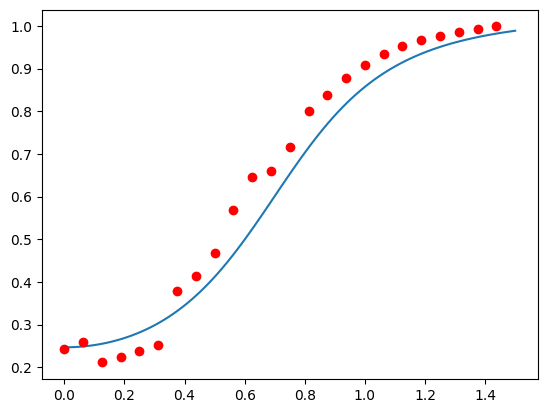

In [73]:
plt.plot(g_exct_values,exct_kk)
plt.plot(g_values[::-1][1:],kk[1:],'ro')

### Two layers

In [68]:
E_2,m_2,kk_2,angles_2 = get_vqe_values_ap_hea(graph,g_values,p=2,optimizer=COBYLA(200),reps=5)

100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


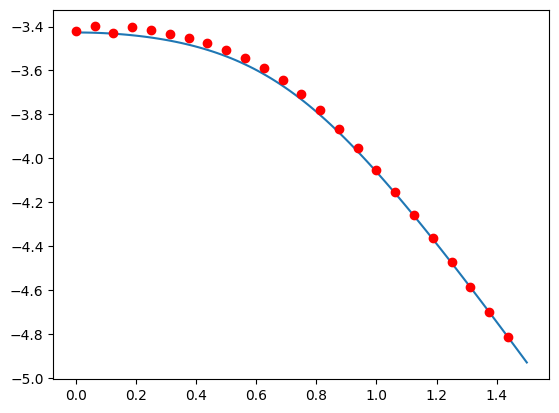

In [69]:
plt.plot(g_exct_values,exct_E)
plt.plot(g_values[::-1][1:],E_2[1:],'ro')

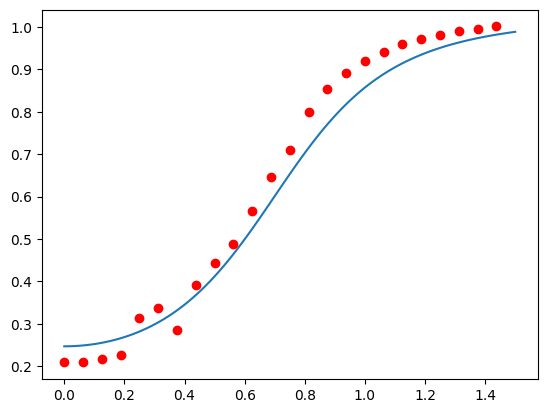

In [70]:
plt.plot(g_exct_values,exct_kk)
plt.plot(g_values[::-1][1:],kk[1:],'ro')

### Three layers

In [78]:
E_3,m_3,kk_3,angles_3 = get_vqe_values_ap_hea(graph,g_values,p=3,optimizer=COBYLA(500),reps=3)

100%|██████████| 25/25 [02:17<00:00,  5.48s/it]


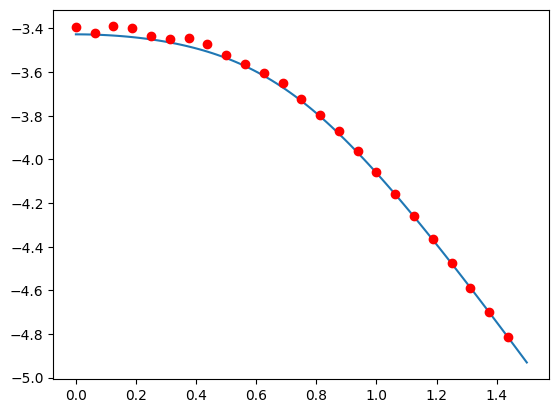

In [81]:
plt.plot(g_exct_values,exct_E)
plt.plot(g_values[::-1][1:],E_3[1:],'ro')

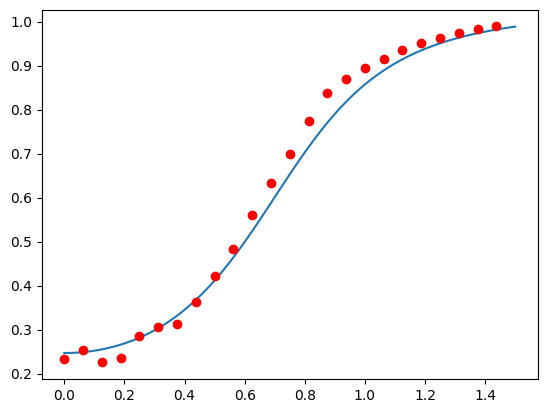

In [82]:
plt.plot(g_exct_values,exct_kk)
plt.plot(g_values[::-1][1:],kk_3[1:],'ro')

## Runtime

In [24]:
def get_vqe_values_hea_rtm(graph,
                          g_values,
                          p=1,
                          hx=0.5,
                          optimizer=COBYLA(),
                          reps=1,
                          backend_id='ibmq_qasm_simulator',
                          options = Options(),
                          initial_iter=500):
    
    """Runs the vqe to simulate the antiparallel model in
    the hardware efficient ansatz for different values of
    the antiparallel field. Here we use ibm runtime"""
    
    # service = QiskitRuntimeService()
    # backend = service.backend(backend_id)
    
    
    
    
    n_qubits = len(graph.nodes())
    
    E_values = np.array([0. for i in range(len(g_values))])
    mag_values = np.array([0. for i in range(len(g_values))])
    kk_values = np.array([0. for i in range(len(g_values))])
    angles_dict = {}
    mag_op = get_mag_op(graph)
    kk_op = get_kk_op(graph)
    aux_operators = [mag_op,kk_op]
    rev_g_values = g_values[::-1]

    ansatz_hea = EfficientSU2(n_qubits,su2_gates='ry',reps=p)
    
    with Session(service=service, backend=backend) as session:
        for i,g in enumerate(tqdm(rev_g_values)):
            cost_operator = get_h_op(graph,hx=hx,ap=g)
            
            if i == 0:
                resampled_energy = 0.
                for j in range(reps):
                    initial_point = np.random.random(ansatz_hea.num_parameters)
                    vqe = VQE(IBM_Estimator(session=session, options=options),
                              ansatz=ansatz_hea,
                              optimizer=COBYLA(initial_iter),
                              initial_point=initial_point)
                    sample_result = vqe.compute_minimum_eigenvalue(operator=cost_operator,
                                                                aux_operators=aux_operators)
                    eigenvalue = sample_result.eigenvalue
                    
                    if eigenvalue < resampled_energy:
                        resampled_energy = eigenvalue
                        result = sample_result
                
                initial_point = result.optimal_point    

            else:
                vqe = VQE(IBM_Estimator(session=session, options=options),
                          ansatz=ansatz_hea,
                          optimizer=optimizer,
                          initial_point=initial_point)
                result = vqe.compute_minimum_eigenvalue(operator=cost_operator,
                                                            aux_operators=aux_operators)
            
            E_values[i] = result.eigenvalue
            mag_values[i] = result.aux_operators_evaluated[0][0]
            kk_values[i] = np.real_if_close(result.aux_operators_evaluated[1][0])
            #optimal angles storage
            angles = list(result.optimal_point)
            angles_dict[str(round(g,14))] = angles
        session.close()


    return E_values,mag_values,kk_values,angles_dict

In [25]:
E_rt,m_rt,kk_rt,angles_rt = get_vqe_values_hea_rtm(graph,g_values,p=1,
                                                   optimizer=COBYLA(500),reps=7,
                                                   initial_iter=500,
                                                   options=options_exct)

 76%|███████▌  | 19/25 [19:57:09<1:00:52, 608.72s/it]   capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
 76%|███████▌  | 19/25 [91:23:07<28:51:30, 17315.12s/it]


KeyboardInterrupt: 

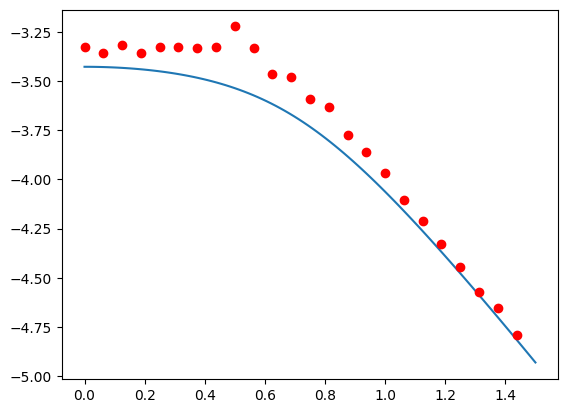

In [22]:
plt.plot(g_exct_values,exct_E)
plt.plot(g_values[::-1][1:],E_rt[1:],'ro')

# MISC

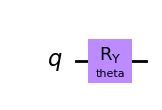

In [88]:
qc = QuantumCircuit(1)
qc.ry(Parameter('theta'),0)
qc.draw('mpl')
#fake_nairobi.configuration().basis_gates

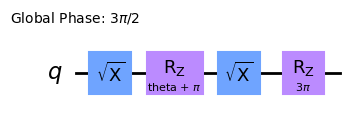

In [89]:
qcn = transpile(qc,basis_gates=fake_nairobi.configuration().basis_gates)
qcn.draw('mpl')

In [49]:
qc = EfficientSU2(4,su2_gates='ry',reps=1)

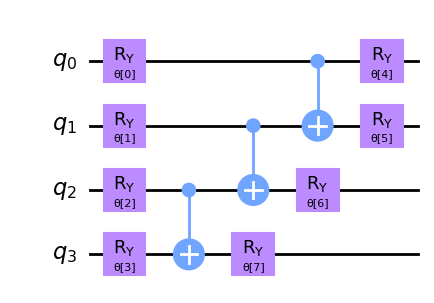

In [50]:
qc.decompose().draw('mpl')

In [1]:
import numpy as np
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.opflow import Z, I, X, Zero, One

/tmp/ipykernel_355201/1866520582.py:3: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import Z, I, X, Zero, One


In [2]:
def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    return hamiltonian

In [3]:
from numpy import linalg
from scipy import linalg
nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=4
E_l = []
P_l = []
energy_levels = []

for k in range(len(b)):
    #In order to use linalg.eig we have to use Operator class
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    # Extract eig
    E_l,P_l = linalg.eig(hamiltonian.data)
    Es = np.sort(E_l)
    energy_levels.append(np.real(Es))

In [4]:
#Define callback function

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

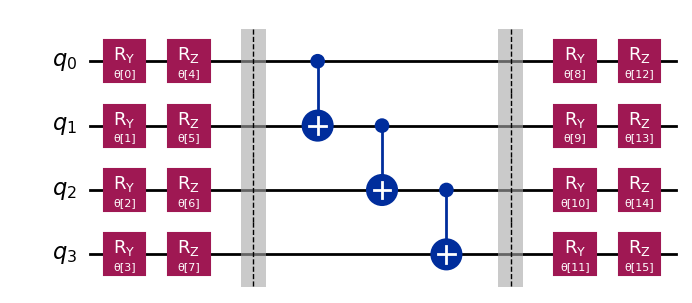

In [5]:
#Define Ansatz, on which the algorithm of VQE starts
from qiskit.circuit.library import EfficientSU2

np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [7]:
from dataclasses import dataclass


@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~350", end="\r", flush=True)


log = VQELog([], [])


In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

In [12]:
service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"

In [14]:
from qiskit.algorithms.minimum_eigensolvers import VQE

In [16]:
# Search for better states using SPSA algorithm
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(150)

In [17]:
# Main calculation
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3

    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    if "simulator" not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            SPSA(1),
            initial_point=result.optimal_point,
        )
        result = vqe.compute_minimum_eigenvalue(hamiltonian)
        print(f"Mitigated result: {result.optimal_value}")

KeyboardInterrupt: 